In [1]:
from pymonntorch import Network, NeuronGroup, Recorder, EventRecorder, Behavior, SynapseGroup
from matplotlib import pyplot as plt
import torch, math, random, time, sympy, os, sys
import numpy as np

""" Set the random seed for reproducibility """;
# torch.manual_seed(0);

In [2]:
class TimeResolution(Behavior):
    def initialize(self, network : Network) -> None:
        network.dt = self.parameter("dt", default = 0.1)

In [3]:
class Current(Behavior):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)

        neuron_G.I_cpy = neuron_G.vector(mode = 0)
        
        if self.F != "different_constants":
            neuron_G.I = neuron_G.vector(mode = self.init_current)
        else:
            neuron_G.I = neuron_G.vector(mode = 0)
            neuron_G.I.copy_(torch.tensor(self.constants))
            
        neuron_G.I_cpy.copy_(neuron_G.I)
        neuron_G.pattern_index = 0
        
        self.prob = 0.0
        self.flag = False
        self.counter = 0
        self.tracker = 0

    def forward(self, neuron_G : NeuronGroup) -> None:
        if self.F == "step":
            neuron_G.I.fill_(self.init_current + self.amplitude) if self.t0 < neuron_G.network.iteration * neuron_G.network.dt < self.t1 else neuron_G.I.fill_(self.init_current)
            neuron_G.I_cpy.copy_(neuron_G.I)
        elif self.F == "different_constants":
            neuron_G.I.copy_(torch.tensor(self.constants))
            neuron_G.I_cpy.copy_(neuron_G.I)
        elif self.F == "noisy_step":
            noise = random.gauss(self.mean, self.std)
            neuron_G.I.fill_(self.init_current + self.amplitude + noise) if self.t0 < neuron_G.network.iteration * neuron_G.network.dt < self.t1 else neuron_G.I.fill_(self.init_current + noise)
            neuron_G.I_cpy.copy_(neuron_G.I)
        elif self.F == "random_pattern":
            pattern = random.choice(self.patterns)
            neuron_G.I.fill_(pattern)
            neuron_G.I_cpy.copy_(neuron_G.I)
        elif self.F == "random_pattern_with_noise":
            #pattern_index = random.choice(range(len(self.patterns)))
            
            
            rem = (neuron_G.iteration // 100) % 4
            if   rem == 0:   pattern_index = 0
            elif rem == 1:   pattern_index = 1
            elif rem == 2:   pattern_index = 0
            else         :   pattern_index = 2
            
            neuron_G.pattern_index = pattern_index
            pattern = self.patterns[pattern_index]
            noise = random.gauss(self.mean, self.std)
            neuron_G.I.copy_(pattern + noise)
            
            
            if not self.flag:
                self.flag = random.random() < self.prob
                self.counter = 0
            
            if self.flag:
                self.flag = not self.counter >= 2
                neuron_G.I += 600
                self.counter += 1
                self.tracker += 1

            neuron_G.I_cpy.copy_(neuron_G.I)


In [4]:
class LIF(Behavior):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
        
        neuron_G.LAST_SPIKE = neuron_G.vector(mode = 0)
        neuron_G.THRESHOLD = neuron_G.vector(mode = self.threshold)
        
        neuron_G.U = neuron_G.vector(mode = self.u_init)
        neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
        neuron_G.A = neuron_G.vector(mode = 0)
        
        neuron_G.U[neuron_G.SPIKE] = self.u_reset
        neuron_G.A = torch.sum(neuron_G.SPIKE.float()) / neuron_G.size
        neuron_G.LAST_SPIKE[neuron_G.SPIKE] = neuron_G.network.iteration * neuron_G.network.dt
        
        """ This parameter is only for experiment (d) in P03 """
        self.dummy_neuron_U = neuron_G.U[-1].item()
        

    def forward(self, neuron_G : NeuronGroup) -> None:
        leakage = -(neuron_G.U - self.u_rest)
        currents = self.R * neuron_G.I
        neuron_G.U += (leakage + currents) / self.tau * neuron_G.network.dt
        neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
        neuron_G.U[neuron_G.SPIKE] = self.u_reset
        neuron_G.A = torch.sum(neuron_G.SPIKE.float()) / neuron_G.size
        neuron_G.LAST_SPIKE[neuron_G.SPIKE] = neuron_G.network.iteration * neuron_G.network.dt
        
        neuron_G.U[-1] = self.dummy_neuron_U



class ForcedNeuron(Behavior):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
            
        self.pattern1 = torch.randint(0, 2, (neuron_G.size,))
            
        neuron_G.SPIKE = neuron_G.vector(mode = 0)
    
    def forward(self, neuron_G : NeuronGroup) -> None:
        neuron_G.SPIKE = random.choice([self.pattern1, self.pattern2])
        

In [5]:
class Dendrite(Behavior):
    def forward(self, neuron_G : NeuronGroup) -> None:
        for synapse in neuron_G.afferent_synapses["All"]:
            neuron_G.I += synapse.I

In [6]:
class Synapse(Behavior):
    def initialize(self, synapse_G : SynapseGroup) -> None:
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
        self.postSIZE = synapse_G.dst.size
        self.preSIZE  = synapse_G.src.size  
        synapse_G.W = synapse_G.matrix(mode = 0) 

        if self.connectivity_mode == "FULL":
            """ Full connectivity """
            self.w = self.J0/self.preSIZE
            synapse_G.W = synapse_G.matrix(mode = f"normal({self.w}, {0.1 * self.w})")
        elif self.connectivity_mode == "FCP":
            """ Random connectivity: fixed coupling probability """
            self.w = self.J0/(self.p * self.preSIZE)
            synapse_G.W = torch.rand(self.preSIZE, self.postSIZE) < self.p
            synapse_G.W = self.W.float() * self.w
        elif self.connectivity_mode == "FPP":
            """ Random connectivity: fixed number of presynaptic partners """
            self.w = self.J0/self.N
            synapse_G.W = torch.zeros(self.preSIZE, self.postSIZE)
            for i in range(self.postSIZE):
                indices = torch.randperm(self.preSIZE)[:self.N]
                synapse_G.W[indices, i] = self.w

    def forward(self, synapse_G : SynapseGroup) -> None:
        preSPIKE = synapse_G.src.SPIKE
        synapse_G.I = torch.sum(synapse_G.W[preSPIKE], axis = 0) * ((-1)**self.isInhibitory)

In [7]:
class STDP(Behavior):
    def initialize(self, synapse_G : SynapseGroup) -> None:
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
        self.trace_pre = synapse_G.src.vector(mode = 0)
        self.trace_post = synapse_G.dst.vector(mode = 0)
    
    def dw(self, synapse_G : SynapseGroup) -> None:
        x = self.trace_pre
        y = self.trace_post
        pre_spike = synapse_G.src.SPIKE.float()
        post_spike = synapse_G.dst.SPIKE.float()
        
        if self.soft_bound == True:
            A_minus_t = self.gamma * (self.wMax - synapse_G.W)**self.beta
            A_plus_t  = self.gamma * (synapse_G.W - self.wMin)**self.beta
        else:
            A_minus_t = self.A_minus
            A_plus_t  = self.A_plus
            
        d_minus = A_minus_t * torch.outer(pre_spike, y)
        d_plus  = A_plus_t  * torch.outer(x, post_spike)
        
        return d_plus - d_minus
        
    def forward(self, synapse_G : SynapseGroup) -> None:
        self.trace_pre += -1 * self.trace_pre / self.tau_trace_plus + synapse_G.src.SPIKE.float()
        self.trace_post += -1 * self.trace_post / self.tau_trace_minus + synapse_G.dst.SPIKE.float()

        synapse_G.W += self.dw(synapse_G = synapse_G) * synapse_G.network.dt
        synapse_G.W = torch.where(synapse_G.W < 0, 0, synapse_G.W)

class Anti_STDP(STDP):
    def initialize(self, synapse_G: SynapseGroup) -> None:
        super().initialize(synapse_G)
    
    def forward(self, synapse_G : SynapseGroup) -> None:
        synapse_G.W -= self.dw(synapse_G = synapse_G) * synapse_G.network.dt
        
class RSTDP(STDP):
    def initialize(self, synapse_G: SynapseGroup) -> None:
        super().initialize(synapse_G)
        synapse_G.c = synapse_G.matrix(mode = 0)
        
    def forward(self, synapse_G : SynapseGroup) -> None:
        self.trace_pre += -1 * self.trace_pre / self.tau_trace_plus + synapse_G.src.SPIKE.float()
        self.trace_post += -1 * self.trace_post / self.tau_trace_minus + synapse_G.dst.SPIKE.float()
        
        stdp = self.dw(synapse_G = synapse_G)
        
        synapse_G.c += ((-synapse_G.c / self.tau_c) + stdp) * synapse_G.network.dt
        synapse_G.W += synapse_G.c * synapse_G.network.dopamine * synapse_G.network.dt
        synapse_G.W = torch.where(synapse_G.W < self.wMin, self.wMin, synapse_G.W)
        synapse_G.W = torch.where(synapse_G.W > self.wMax, self.wMax, synapse_G.W)
        
class Dopamine(Behavior):
    def initialize(self, network : Network) -> None:
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
        network.dopamine = self.init_dopamine
        self.dopamine_array = torch.zeros(self.iterations)
        
    def forward(self, network : Network) -> None:
        synapse_G = network.find_objects(key = "synapse")
        pre, post = synapse_G[0].src, synapse_G[0].dst

        def DA(pre, post, coef) -> float:
            """ Specific for this experiment """
            pattern_index = pre.pattern_index
            reward = 0
            if pattern_index == 1 and post.SPIKE[0].item():
                reward += 1
            if pattern_index == 1 and post.SPIKE[1].item():
                reward -= 1
            if pattern_index == 2 and post.SPIKE[0].item():
                reward -= 1
            if pattern_index == 2 and post.SPIKE[1].item():
                reward += 1
            return reward * coef
            
        da = DA(pre, post, self.coef)
        network.dopamine += ((-network.dopamine / self.tau_dopamine) + da) * network.dt
        self.dopamine_array[network.iteration - 1] = network.dopamine
        
class Sim(Behavior):
    def initialize(self, synapse_G : SynapseGroup) -> None:
        synapse_G.similarity = 0
    
    def forward(self, synapse_G : SynapseGroup) -> None:
        A = synapse_G.W[:, 0]
        B = synapse_G.W[:, 1]
        
        synapse_G.similarity = torch.inner(A, B) / (torch.norm(A) * torch.norm(B))

In [8]:
ITERATIONS = 1000
sim = Sim()

lif_pre_params = {
    "u_rest" : -80,
    "u_reset" : -90,
    "u_init" : "normal(-75, 5)",
    "tau" : 10,
    "R" : 1,
    "threshold" : -60,
    "refractoryON" : False,
    "refractoryMODE" : "BLOCK_CURRENT",
    "theta0" : -30,
    "theta" : 10,
    "tau_a" : 200,
    "refractory_T" : 5,
}; lif_pre = LIF(params = lif_pre_params)

lif_post_params = {
    "u_rest" : -80,
    "u_reset" : -90,
    "u_init" : "normal(-75, 3)",
    "tau" : 10,
    "R" : 1,
    "threshold" : -65,
    "refractoryON" : False,
    "refractoryMODE" : "BLOCK_CURRENT",
    "theta0" : -30,
    "theta" : 10,
    "tau_a" : 200,
    "refractory_T" : 5,
}; lif_post = LIF(params = lif_post_params)

I_constant_params = {
    "F" : "constant",
    "init_current" : 0,
}; I_constant = Current(params = I_constant_params)

I_step_params = {
    "F" : "step",
    "init_current" : 0,
    "t0" : 30,
    "t1" : 70,
    "amplitude" : 60,
}; I_step = Current(params = I_step_params)

I_noisy_step_params = {
    "F" : "noisy_step",
    "init_current" : 0,
    "t0" : 30,
    "t1" : 70,
    "amplitude" : 60,
    "mean" : 0,
    "std" : 5,
}; I_noisy_step = Current(params = I_noisy_step_params)

I_random_pattern_with_noise_params = {
    "init_current" : 0,
    "F" : "random_pattern_with_noise",
    "patterns" : [
                    torch.tensor([0, 0, 0], dtype = torch.float32),
                    torch.tensor([200, 0, 0], dtype = torch.float32),
                    torch.tensor([0, 200, 0], dtype = torch.float32),
                  ],
    "mean" : 0,
    "std" : 1,
}; I_random_pattern_with_noise = Current(params = I_random_pattern_with_noise_params)

I_pre = I_random_pattern_with_noise
pre_behavior = {
    2 : I_pre,
    4 : lif_pre,
    6 : Recorder(tag = "pre_recorder", variables = ["U", "I", "A"]),
    8 : EventRecorder(tag = "pre_event_recorder", variables = ["SPIKE"]),
}

I_post = I_constant
post_behavior = {
    2 : I_post,
    4 : Dendrite(),
    6 : lif_post,
    8 : Recorder(tag = "post_recorder", variables = ["U", "I", "A"]),
    10 : EventRecorder(tag = "post_event_recorder", variables = ["SPIKE"]),
}

synapse_prams = {
    "transfer_mode" : "Dirac",
    "connectivity_mode" : "FULL",
    "N" : 150,
    "p" : 0.9,
    "tau_syn" : 5,
    "g" : 20,
    "E_syn" : 0,
    "J0" : 10,
    "isInhibitory" : 0
}

stdp_params = {
    "A_plus" : 2,
    "A_minus" : 2,
    "tau_trace_plus" : 40,
    "tau_trace_minus" : 40,
    "soft_bound" : False,
    "wMax" : 10,
    "wMin" : 0.1,
    "beta" : 2,
    "gamma" : 0.01,
}; stdp = STDP(params = stdp_params)

dopamine_params = {
    "init_dopamine" : 0,
    "tau_dopamine" : 1,
    "coef" : 50,
    "iterations" : ITERATIONS,
}; dopamine = Dopamine(params = dopamine_params)

rstdp_params = {
    "A_plus" : 2,
    "A_minus" : 1,
    "tau_trace_plus" : 40,
    "tau_trace_minus" : 40,
    "soft_bound" : False,
    "wMax" : 10,
    "wMin" : 0.1,
    "beta" : 2,
    "gamma" : 0.01,
    
    "tau_c" : 4,
}; rstdp = RSTDP(params = rstdp_params)



Network['Network_1', 'Network'](Neurons: tensor(6)|2 groups, Synapses: tensor(9)|1 groups){1:TimeResolution(dt=0.1,)2:Dopamine(params={'init_dopamine': 0, 'tau_dopamine': 1, 'coef': 50, 'iterations': 1000},)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](3){2:Current(params={'init_current': 0, 'F': 'random_pattern_with_noise', 'patterns': [tensor([0., 0., 0.]), tensor([200.,   0.,   0.]), tensor([  0., 200.,   0.])], 'mean': 0, 'std': 1},)4:LIF(params={'u_rest': -80, 'u_reset': -90, 'u_init': 'normal(-75, 5)', 'tau': 10, 'R': 1, 'threshold': -60, 'refractoryON': False, 'refractoryMODE': 'BLOCK_CURRENT', 'theta0': -30, 'theta': 10, 'tau_a': 200, 'refractory_T': 5},)6:Recorder(variables=['U', 'I', 'A'],gap_width=0,max_length=None,auto_annotate=True,tag=pre_recorder,)8:EventRecorder(variables=['SPIKE'],gap_width=0,max_length=None,auto_annotate=True,tag=pre_event_recorder,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](3){2:Current(params={'F': 'constant', 'init_current': 0},)4:De

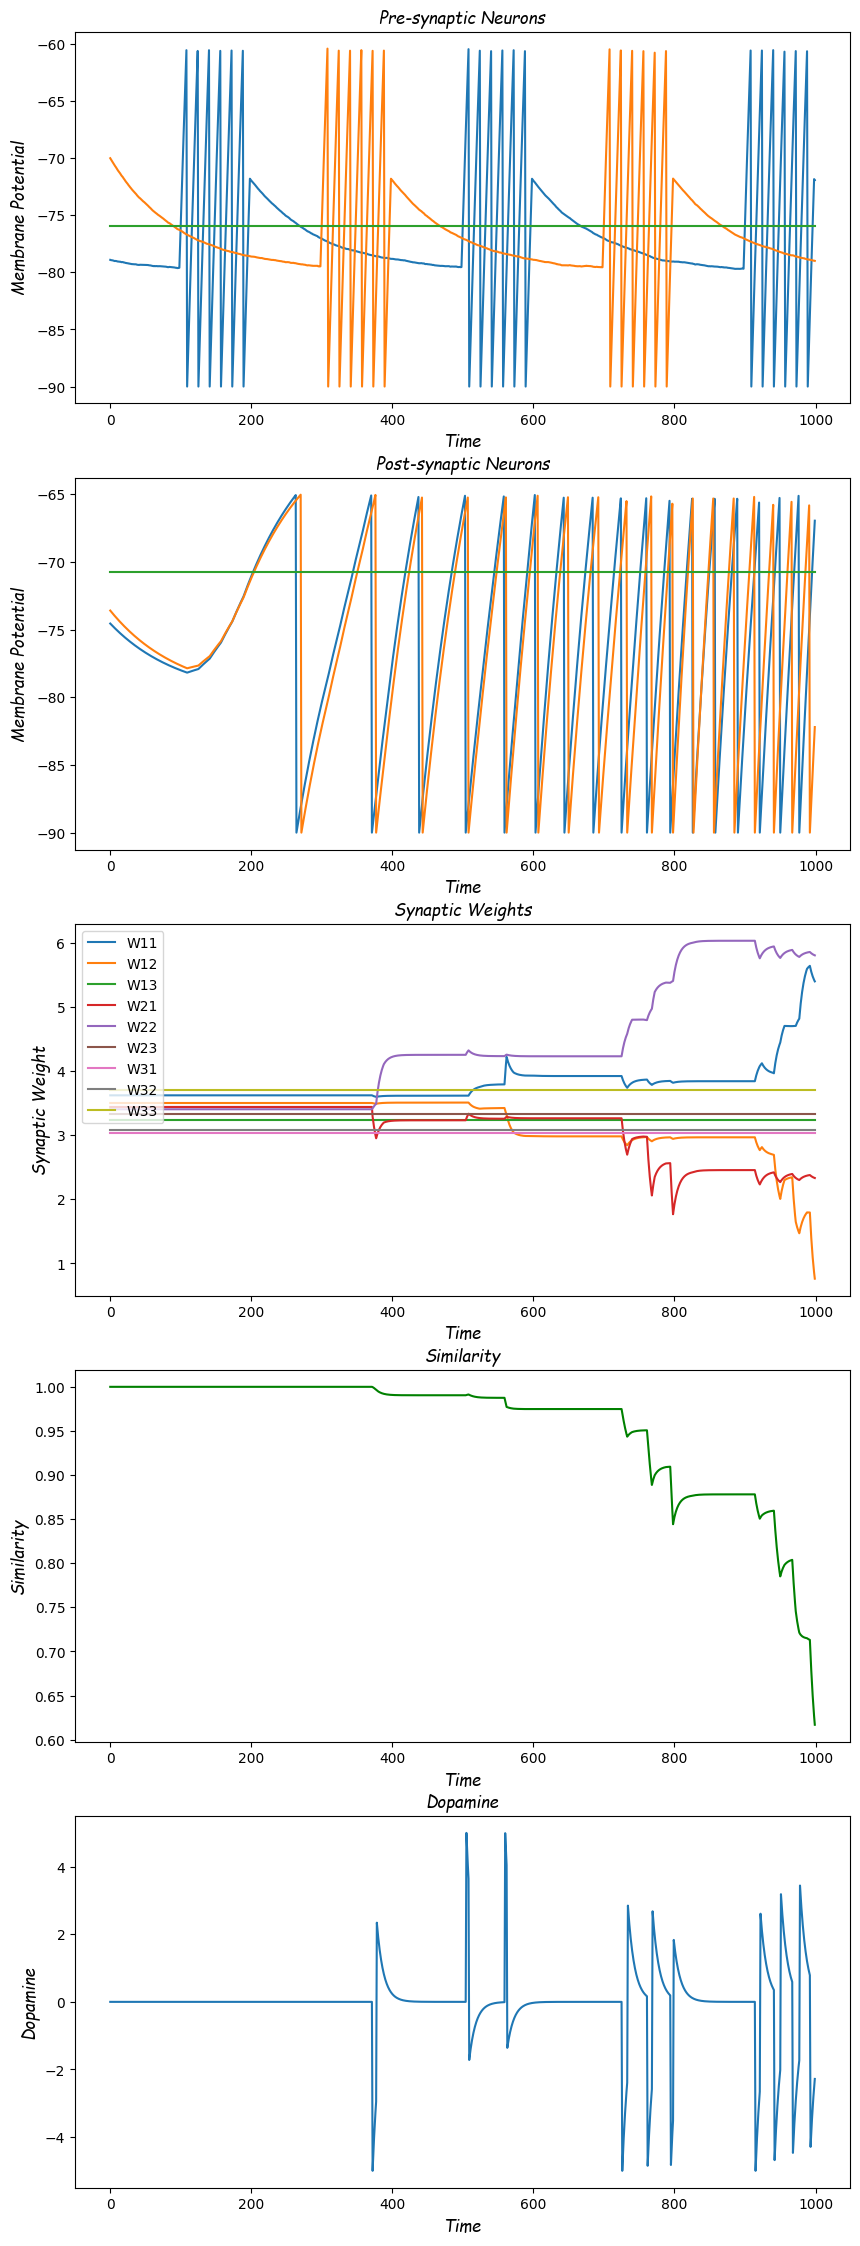

0 0


In [9]:
PRE_CNT = 3
POST_CNT = 3

network = Network(
    behavior={
            1 : TimeResolution(dt = 0.1), 
            2 : dopamine,
            }, 
    dtype=torch.float64, 
    device = "cpu",
    synapse_mode = "SxD")

pre = NeuronGroup(size = PRE_CNT, behavior = pre_behavior, net = network)
post = NeuronGroup(size = POST_CNT, behavior = post_behavior, net = network)

synapse_G = SynapseGroup(net = network, src = pre, dst = post, 
                         behavior = {
                             3 : Synapse(params = synapse_prams), 
                             4 : rstdp, 
                             5 : sim,
                             6 : Recorder(tag = "synapse_recorder", variables = ["I", "W", "similarity"])}, tag = "synapse")

network.initialize()
network.simulate_iterations(ITERATIONS)

fig, axs = plt.subplots(5,1)
fig.set_size_inches(10, 28)

axs[0].plot(network["pre_recorder", 0].variables["U"][:, :])
axs[0].set_xlabel("Time", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[0].set_ylabel("Membrane Potential", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[0].set_title("Pre-synaptic Neurons", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")

axs[1].plot(network["post_recorder", 0].variables["U"][:, :])
axs[1].set_xlabel("Time", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[1].set_ylabel("Membrane Potential", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[1].set_title("Post-synaptic Neurons", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")

W = network["synapse_recorder", 0].variables["W"]
for k in range(1, PRE_CNT + 1):
    for j in range(1, POST_CNT + 1):
        axs[2].plot([i for i in range(ITERATIONS)], torch.flatten(W[:,k-1:k,j-1:j]), label=f"W{k}{j}")
axs[2].set_xlabel("Time", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[2].set_ylabel("Synaptic Weight", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[2].set_title("Synaptic Weights", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[2].legend(loc = "upper left")

similarity = network["synapse_recorder", 0].variables["similarity"]
axs[3].plot(similarity, c = "green")
axs[3].set_xlabel("Time", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[3].set_ylabel("Similarity", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[3].set_title("Similarity", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")

axs[4].plot(dopamine.dopamine_array)
axs[4].set_xlabel("Time", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[4].set_ylabel("Dopamine", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
axs[4].set_title("Dopamine", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
plt.show()





# display(network.find_objects(key = "synapse")[0].dst.SPIKE.float()[0].item())
# display(network.iteration)

print(I_pre.tracker // 5, I_post.tracker // 5)
